In [1]:
#### Functions to load data

from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from collections import defaultdict
import torchvision.transforms as T
from datetime import datetime
from tensorflow import keras

In [2]:


"""
Function for loading the satellite images
Arguments:
 selectedDataset - can be "2019-07" - e.g. specific month
                          "" - all months
 pictureTypes - list defining what sort of constellations are loaded
                "dnc" - 
                "dnm" - 24-hour Microphysics RGB

 pictureSize - Size to resize images to after they are read from disk. Defaults to (256, 256).
Returns:
  2 dictionaries
  dates - dates corresponding to pictures
  pictures - satellite pictures
"""


def loadSatelliteImages(selectedDatasets=["2019-07"], pictureTypes=["dnc", "dnm"], pictureSize=(256, 256)):
    pictures = defaultdict(lambda: defaultdict(list))
    dates = defaultdict(lambda: defaultdict(list))

    for selectedDataset in selectedDatasets:
        for pictureType in pictureTypes:
            satellitePictureNames = os.listdir(os.path.join(".", "data", selectedDataset, pictureType))

            for satellitePictureName in satellitePictureNames:
                # Load image
                imageDateStr = satellitePictureName.replace("dnc-", "").replace("dnm-", "").replace(".png", "")
                #Parse date to datetime 2019-07-01-05-45
                imageDate = datetime.strptime(imageDateStr, "%Y-%m-%d-%H-%M")
                img = image.load_img(os.path.join(".", "data", selectedDataset,
                                                  pictureType, satellitePictureName),
                                     target_size=pictureSize)
                # Convert to np array and add to list
                pictures[selectedDataset][pictureType].append(np.array(img))
                dates[selectedDataset][pictureType].append(imageDate)
            dates[selectedDataset][pictureType] = np.array(dates[selectedDataset][pictureType])
            pictures[selectedDataset][pictureType] = np.array(pictures[selectedDataset][pictureType])
            #Argsort
            sortedDates = np.argsort(dates[selectedDataset][pictureType])
            dates[selectedDataset][pictureType] = dates[selectedDataset][pictureType][sortedDates]
            pictures[selectedDataset][pictureType] = pictures[selectedDataset][pictureType][sortedDates]

    return pictures, dates


In [3]:
npixel = 128

In [4]:

sat, labels = loadSatelliteImages(selectedDatasets=["2019-09"], pictureTypes=["dnc"], pictureSize=(npixel, npixel))

## Transforming images to dataset

In [5]:
"""
Function for creating samples out of satellite data. Each row of X contains given number 
(imagesInSample) used to predict future weather. Rows of y are similar to y, although shifted
by one time interval

Arguments
dataDict - dictionary, which contains image data
X_imagetype - the type of images that are requested for X
Y_imagetype - the type of images that are requested for y
imagesInSample - number of images in data row
"""
def createDataSetFromImages(dataDict, X_imagetype, Y_imagetype, selectChannelX=None, selectChannelY=None, imagesInSample=6):
    X = []
    y = []
    for month in dataDict.keys():
        if selectChannelX is None:
            X_subset = dataDict[month][X_imagetype]
        else:
            X_subset = dataDict[month][X_imagetype][:,:,:,selectChannelX]
            # Add a channel dimension if using only one channel
            X_subset = np.expand_dims(X_subset, axis=-1)

        if selectChannelY is None:
            y_subset = dataDict[month][Y_imagetype]
        else:
            y_subset = dataDict[month][Y_imagetype][:,:,:,selectChannelY]
            y_subset = np.expand_dims(y_subset, axis=-1)
        assert len(X_subset)==len(y_subset) # Lengths must match
        for i in range(0, len(X_subset)-imagesInSample-1):
            #Select images so that y is shifted by one frame
            selected_X = X_subset[i:i+imagesInSample]
            selected_y = y_subset[i+1:i+1+imagesInSample]
            #print(np.sum(selected_X[1]-selected_y[0]))
            X.append(selected_X)
            y.append(selected_y)
    return np.array(X), np.array(y)

In [6]:
# Normalize the data to the 0-1 range.
for dataSet in sat.keys():
    for pictureType in sat[dataSet].keys():
        sat[dataSet][pictureType] = sat[dataSet][pictureType] / 255

In [7]:
X, y = createDataSetFromImages(sat, "dnc", "dnc", 1, 1)

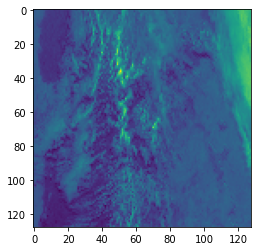

In [8]:
#Check image
plt.imshow(X[318][1])

In [9]:
X.shape

(2873, 6, 128, 128, 1)

In [10]:
y.shape

(2873, 6, 128, 128, 1)

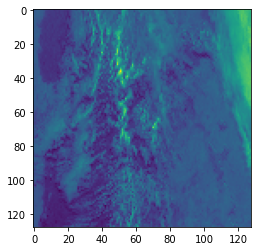

In [11]:
plt.imshow(y[318][0])

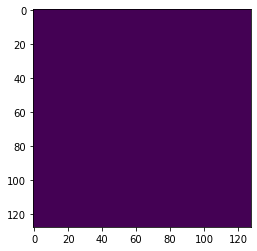

In [12]:
plt.imshow(X[318][1]-y[318][0])

In [13]:
# Split into train and validation sets
indexes = np.arange(X.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.8 * X.shape[0])]
val_index = indexes[int(0.8 * X.shape[0]) :]
train_X = X[train_index]
train_y = y[train_index]
val_X = X[val_index]
val_y = y[val_index]

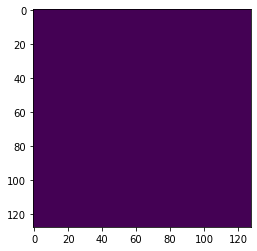

In [14]:
plt.imshow(val_X[200][1]-val_y[200][0])

In [15]:
#Check that dims match
print("Training Dataset Shapes: " + str(train_X.shape) + ", " + str(train_y.shape))
print("Validation Dataset Shapes: " + str(val_X.shape) + ", " + str(val_y.shape))

Training Dataset Shapes: (2298, 6, 128, 128, 1), (2298, 6, 128, 128, 1)
Validation Dataset Shapes: (575, 6, 128, 128, 1), (575, 6, 128, 128, 1)


# Load trained model

In [16]:
model = keras.models.load_model('savedModel_2a')

2021-12-08 11:24:41.433166: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-08 11:24:41.434336: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Compare

In [19]:
idx = 300

## Real

7888.235294117647
8057.733333333333
8452.19607843137
8429.121568627452
8413.50588235294
7243.850980392157


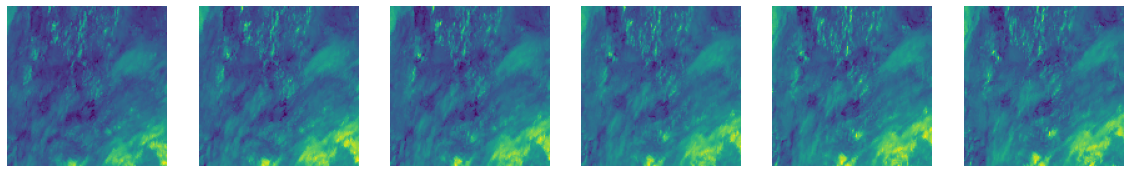

In [20]:
plt.rcParams['figure.figsize'] = (20.0, 14.0) # set default size of plots
for i in range(len(val_y[idx])):
    plt.subplot(1, 6, i+1)
    print(np.sum(val_y[idx,i]))
    plt.imshow(val_y[idx,i])
    plt.axis("off")

## Predicted

2021-12-08 11:25:00.092796: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


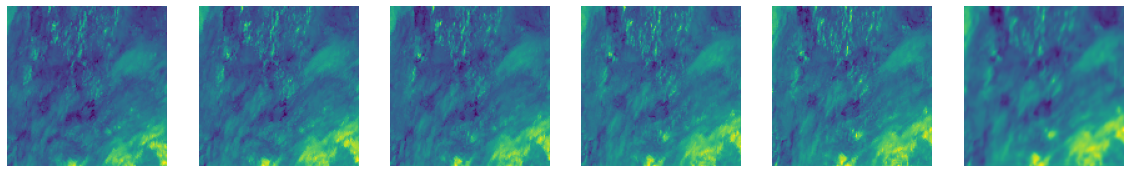

In [21]:
prediction = model.predict(np.expand_dims(val_X[idx], axis=0))

plt.rcParams['figure.figsize'] = (20.0, 14.0) # set default size of plots
for i in range(len(prediction[0])):
    plt.subplot(1, 6, i+1)
    plt.imshow(prediction[0,i])
    plt.axis("off")

## Diff

31.660006000715143
-0.8668399910132152
-6.124622512097471
16.92903900871088
30.10529294645084
-1207.1396787851463


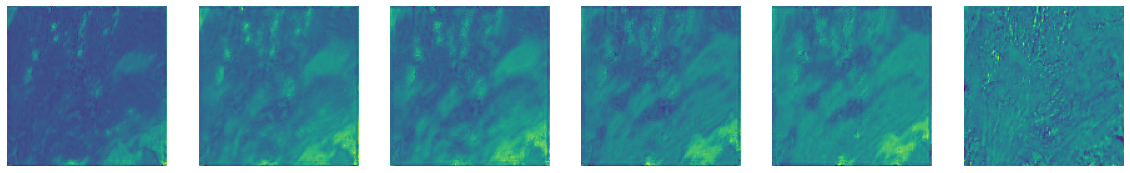

In [22]:
plt.rcParams['figure.figsize'] = (20.0, 14.0) # set default size of plots
for i in range(len(val_y[idx])):
    plt.subplot(1, 6, i+1)
    diff = val_y[idx,i]-prediction[0,i]
    print(np.sum(diff))
    plt.imshow(diff)
    plt.axis("off")